# Generate data

This notebook requires `BTInvert` to run the simulations to generate training data

In [4]:
code_dir = "../UXO_protected/+BTInvertPY"

In [2]:
import numpy as np
import os
import h5py
import pandas as pd
from scipy import stats
import torch

import matplotlib.pyplot as plt
from matplotlib import cm as cmap
from matplotlib import colors
from matplotlib.colors import Normalize
from mpl_toolkits import mplot3d

from string import ascii_lowercase

import uxo_utils
from uxo_utils import (
    SensorInfo, Model, preCalcLoopCorners, FModParam, 
    forwardWithQ, sensorCoords2RxCoords, hprimary, formQmatrix
)

In [3]:
from matplotlib import rcParams
rcParams['font.size'] = 14
np.random.seed(2020)
torch.manual_seed(13)

## load sensor info and ordnance data

In [5]:
sensorinfo = uxo_utils.load_sensor_info()
ordnance = uxo_utils.load_ordnance_dict()

In [6]:
ordnance.keys()

dict_keys(['105mm', '2.36-in', '2.75-in', '2.95-in', '20-lb Bomb', '25-lb Bomb', '3-in', '3.5-in', '30mm', '37mm', '4-in', '4-in Sphere', '4.2-in', '4.5-in', '4.52-in', '5-lb Bomb', '57mm', '60mm', '66mm', '75mm', '76mm', '81mm', '90mm', '106mm', 'ISO Large', 'ISO Medium', 'ISO Small', '2.25-in', '10-lb Bomb', '100-lb Bomb', 'Booster', 'Fuze', '120mm', 'Grenade', '152mm', 'Igniter Bomb', 'Landmine', 'Livens Projectile', 'Depth Charge', 'Parachute Flare', 'Rifle Grenade', '155mm', 'Dual Mode HE Rocket', 'Smoke Pot', 'Underwater Mine', '16-in', '175mm', 'Rocket Motor', '20mm', '250-lb Bomb', '25mm', '35mm', '40mm', '105mm SABOT', '5-in', '50 cal', '6-in', '7.2-in Depth Charge', '8-in', 'Bomblet', 'Booster Cup'])

## set up survey parameters
- x is cross-line
- y is inline

In [7]:
ntx = len(sensorinfo.transmitters)
ymax = 3. 
y_spacing = 0.2
dy = y_spacing / ntx
nloc = int(ymax/dy)
ncycles = int(nloc/ntx)

y = np.linspace(0, ymax-dy, nloc)
x = np.zeros(nloc)
z = 0.28 * np.ones(nloc)

pitch = np.zeros(nloc)
roll = np.zeros(nloc)
yaw = np.zeros(nloc)  # moving north (sensor in typical orientation)

txnum = np.kron(np.ones(ncycles), np.arange(ntx))

In [8]:
# Convert sensor location coordinates to Rx locations
pos, mnum = sensorCoords2RxCoords(
    sensorinfo=sensorinfo,
    x = x, 
    y = y, 
    z = z, 
    pitch = pitch, 
    roll = roll, 
    yaw = yaw,
    txnum = txnum
)

pitch = np.concatenate([np.tile(x,pos[i].shape[0]) for i,x in enumerate(pitch)])
roll = np.concatenate([np.tile(x,pos[i].shape[0]) for i,x in enumerate(roll)])
yaw = np.concatenate([np.tile(x,pos[i].shape[0]) for i,x in enumerate(yaw)])
pos = np.concatenate(pos,axis=0)

In [28]:
np.save("./data/pos.npy", pos)

## ordnance objects

In [26]:
times = ordnance["ISO Small"]["times"]
np.save("./data/times.npy", times)

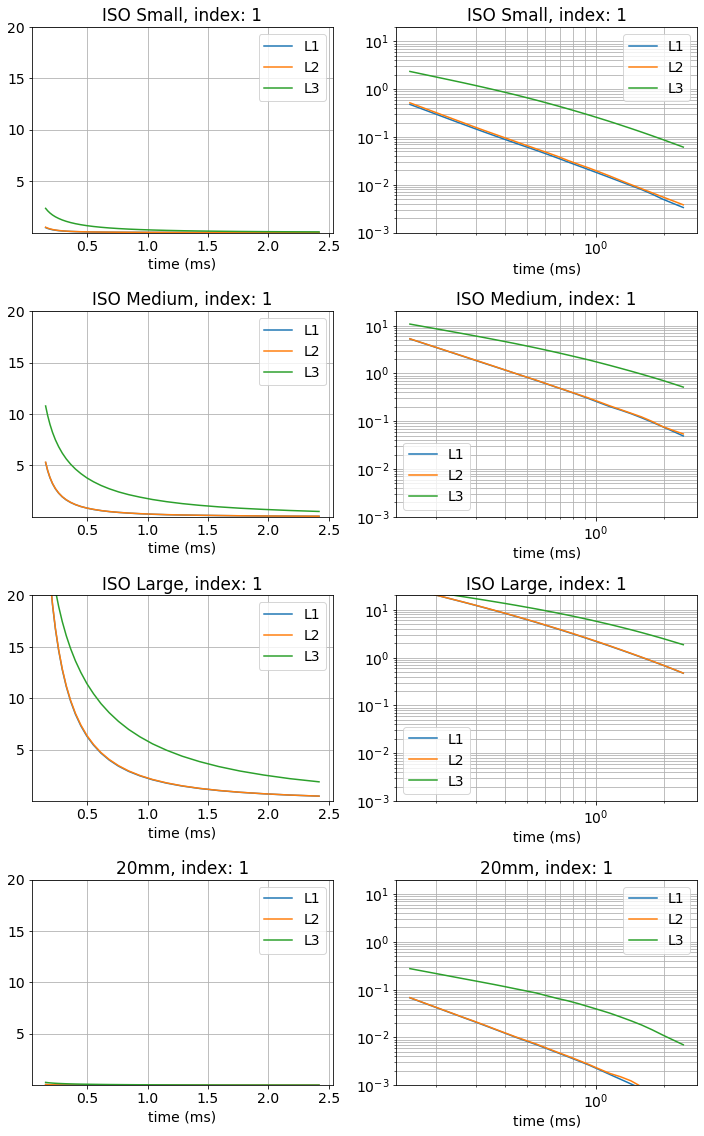

In [10]:
plot_me = {
    "ISO Small": 1,
    "ISO Medium": 1,
    "ISO Large": 1,
    "20mm": 1
}
fig, ax = plt.subplots(len(plot_me.keys()), 2, figsize=(10, 4*len(plot_me.keys())))

for i, key in enumerate(plot_me.keys()):
    for l in ["L1", "L2", "L3"]:
        L = ordnance[key][l][plot_me[key]]
        ax[i, 0].plot(times, L, label=l)
        ax[i, 1].loglog(times, L, label=l)

    for a in ax[i, :]:
        a.set_title(f"{key}, index: {1}")
        a.grid(which="both")
        a.legend()
        a.set_xlabel("time (ms)")
        a.set_ylim([1e-3, 20])
        
plt.tight_layout()

## ranges of parameters

In [11]:
depth_ranges = [
    np.r_[0, 0.5], 
    np.r_[0, 0.5],
    np.r_[0, 0.5],
    np.r_[0, 0.5],
]

buffer = 0.5*np.r_[-1, 1]

x_range = np.r_[-1.25, 1.25] + buffer
y_range = np.r_[0., ymax] + buffer

yaw_range = np.r_[0, 2*np.pi]
pitch_range = np.r_[0, 2*np.pi]
roll_range = np.r_[0, 2*np.pi]

noise_amplitudes = np.r_[1e-5, 1e-2]

def generate_random_variables(n, bounds, log_scaled=False):
    if log_scaled is True:
        if any(bounds == 0):
            return np.zeros(n)
        bounds = np.log(bounds)
        return np.exp(bounds.min() + (bounds.max() - bounds.min()) * np.random.rand(n))
    return bounds.min() + (bounds.max() - bounds.min()) * np.random.rand(n)

In [12]:
ntrain = 2048*4
ntest = 1024
nvalid = 1024

class_dict = {
    0: "not TOI",
    1: "ISO Small",
    2: "ISO Medium", 
    3: "ISO Large",
    4: "clutter",
}
n_class = len(class_dict.keys())

clutter_dict = {
#     0: "30mm",
    0: "20mm",
#     2: "ISO Small Plate",
    1: "ISO Small Sphere",
#     4: "Grenade"
}

In [13]:
labels_train = np.random.choice(n_class, ntrain)
labels_test = np.random.choice(n_class, ntest)
labels_valid = np.random.choice(n_class, nvalid)

def generate_parameters(labels):
    n = len(labels)
    
    depths = np.zeros(n)
    
    x = generate_random_variables(n, x_range)
    y = generate_random_variables(n, y_range)

    yaw = generate_random_variables(n, yaw_range)
    pitch = generate_random_variables(n, pitch_range)
    roll = generate_random_variables(n, roll_range)
    
    noise_amplitude = generate_random_variables(n, noise_amplitudes, True)
    
    polarizations = np.zeros(n, dtype=int)
    clutter = np.zeros(n, dtype=int)
    
    for i in np.unique(labels):
        ii = labels == i  # indices of the labels
        
        if class_dict[i] != "not TOI":
            depths[ii] = generate_random_variables(ii.sum(), depth_ranges[i-1])
            
            if class_dict[i] == "clutter":
                j = np.random.choice(len(clutter_dict.keys()), ii.sum())
                clutter[ii] = j
                for key, val in clutter_dict.items():
                    jj = j == key
                    if val == "30mm" or val == "20mm":
                        polarizations[ii][jj] = np.ones(jj.sum())
                    else: 
                        polarizations[ii][jj] = np.random.choice(len(ordnance["ISO Small"]["L3"]), jj.sum())
            else:
                polarizations[ii] = np.random.choice(len(ordnance[class_dict[i]]["L3"]), ii.sum())
                                 
    
    return pd.DataFrame({
        "label": labels,
        "depth": depths,
        "x": x,
        "y": y,
        "z": -depths,
        "yaw": yaw,
        "pitch": pitch,
        "roll": roll, 
        "noise_amplitude": noise_amplitude,
        "polarizations": polarizations,
        "clutter_type": clutter
    })

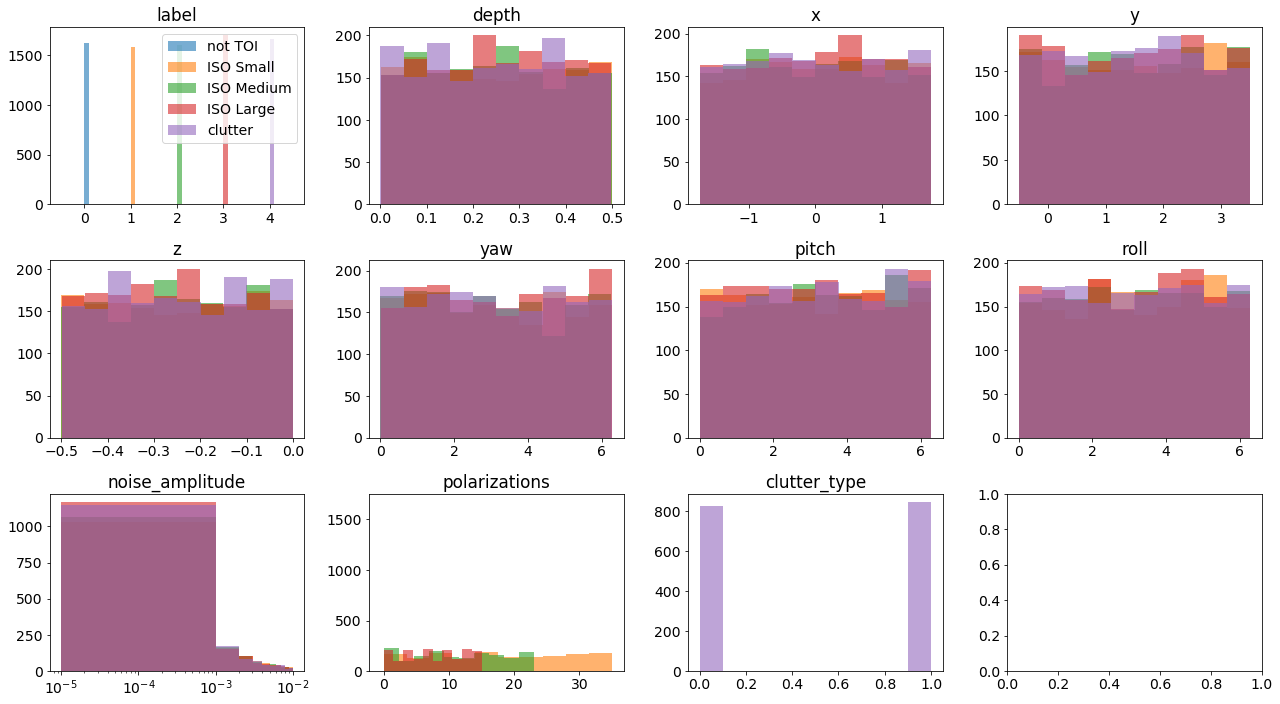

In [14]:
params_train = generate_parameters(labels_train) 
params_test = generate_parameters(labels_test) 
params_valid = generate_parameters(labels_valid) 

fig, ax = plt.subplots(3, 4, figsize=(18, 10))
ax = ax.flatten()

i = 0
for key, val in params_train.items():
    for j in range(n_class):
        inds = labels_train == j
        if key != "label" and j == 0: 
            pass  # these parameters are irrelevant if there is no object
        elif key == "noise_amplitude":
            ax[i].hist(val[inds], 10, color=f"C{j}", alpha=0.6)
            ax[i].set_xscale("log")
        elif (key == "clutter_type") and (j == n_class-1):
            ax[i].hist(val[inds], 10, color=f"C{j}", alpha=0.6)
        elif key != "clutter_type":
            ax[i].hist(val[inds], 10, color=f"C{j}", alpha=0.6)
    ax[i].set_title(key)
    i += 1

ax[0].legend(list(class_dict.values()))
plt.tight_layout()

### save training parameters

In [19]:
params_train.to_hdf("./data/params_train.h5", key="df", mode="w")
params_test.to_hdf("./data/params_test.h5", key="df", mode="w")
params_valid.to_hdf("./data/params_valid.h5", key="df", mode="w")

## set up forward simulations

In [20]:
def noise_model(times, amplitude=0.1, slope=-1, intercept=-0.5):
    return amplitude * np.exp(slope * np.log(times) + intercept)

In [21]:
# figuring out where all of the vertices are in coordinate system -- gives us location of vertices 
Tx_indices_rot, Rx_indices_rot = preCalcLoopCorners(
    sensorinfo=sensorinfo, mnum=mnum, rlist=pos, pitch=pitch, roll=roll, yaw=yaw
) 

# convienence object for inputs to fwd modelling 
st = FModParam(sensorinfo, pos, mnum, times, Tx_indices_rot, Rx_indices_rot)  

In [22]:
def run_simulations(parameters, st=st, mnum=mnum, ncycles=ncycles):
    data = []
    noise_data = []
    for i, l in enumerate(parameters["label"]):
        if l == 0:
            # this can later be replaced with random noise or other structured but uninteresting signal
            V = np.zeros((mnum.max()+1, ncycles, len(times)))
#             for j in range(mnum.max()+1):
#                 mnum_noise = np.random.choice(mnum.max(), 1)[0]
#                 d = noise_test_plot_mn[mnum_noise]
#                 i_start = np.random.choice(d.shape[1], 1)[0]
#                 if i_start > d.shape[1] - ncycles:
#                     V[j, :, :] = np.hstack([
#                         d[:, i_start:], 
#                         np.fliplr(d[:, -(ncycles - (d.shape[1]-i_start)):])
#                     ]).T
#                 else: 
#                     V[j, :, :] = d[:, i_start:i_start+ncycles].T
        else: 
            xyz = np.r_[parameters["x"][i], parameters["y"][i], parameters["z"][i]]
            ypr = np.r_[parameters["yaw"][i], parameters["pitch"][i], parameters["roll"][i]]
            pi = parameters["polarizations"][i]
            
            if class_dict[l] != "clutter":
                L3 = ordnance[class_dict[l]]["L3"][pi]
                L2 = ordnance[class_dict[l]]["L2"][pi]
                L1 = ordnance[class_dict[l]]["L1"][pi]
            else:
                clutter_type = parameters["clutter_type"][i]
                clutter_name = clutter_dict[clutter_type]
                if clutter_name in ["30mm", "20mm"]:
                    L3 = ordnance[clutter_name]["L3"][pi]
                    L2 = ordnance[clutter_name]["L2"][pi]
                    L1 = ordnance[clutter_name]["L1"][pi]
                elif clutter_name == "ISO Small Plate":
                    L3 = ordnance["ISO Small"]["L3"][pi]
                    L2 = ordnance["ISO Small"]["L3"][pi] # L2 == L3 is like a plate
                    L1 = ordnance["ISO Small"]["L1"][pi]
                elif clutter_name == "ISO Small Sphere":
                    L3 = ordnance["ISO Small"]["L1"][pi]
                    L2 = ordnance["ISO Small"]["L1"][pi] # L1 == L2 == L3 is a sphere
                    L1 = ordnance["ISO Small"]["L1"][pi] # L1 == L2 == L3 is a sphere
                                  

            mod = Model(xyz=xyz, gba=ypr, l3=L3, l2=L2, l1=L1, times=times)
            V = forwardWithQ(mod, st) # nT/s (some version of db/dt)
            V = V.reshape(ncycles, mnum.max()+1, len(times))
            V = np.swapaxes(V, 0, 1)
        data.append(V)
        noise_data.append(
            V + 
            np.random.randn(np.prod(V.shape)).reshape(V.shape) * 
            noise_model(times, amplitude=parameters["noise_amplitude"][i])
        )
    return data, noise_data

In [23]:
%%time
data_clean_train, data_train = run_simulations(params_train)

CPU times: user 2min 21s, sys: 5.52 s, total: 2min 27s
Wall time: 37.3 s


In [24]:
%%time
data_clean_test, data_test = run_simulations(params_test)
data_clean_valid, data_valid = run_simulations(params_valid)

CPU times: user 45 s, sys: 2.67 s, total: 47.6 s
Wall time: 13.9 s


In [27]:
np.save("./data/data_clean_train.npy", np.stack(data_clean_train, 0))
np.save("./data/data_train.npy", np.stack(data_train, 0))

np.save("./data/data_clean_test.npy", np.stack(data_clean_test, 0))
np.save("./data/data_test.npy", np.stack(data_test, 0))

np.save("./data/data_clean_valid.npy", np.stack(data_clean_valid, 0))
np.save("./data/data_valid.npy", np.stack(data_valid, 0))

## plot some sample data

In [29]:
pos = np.swapaxes(pos.reshape(ncycles, mnum.max()+1, 3), 0, 1)

In [30]:
dind = 28
d = data_train[dind]

print(f"class: {class_dict[labels_train[dind]]}, data shape: {d.shape}")

params_train.iloc[dind]

class: ISO Medium, data shape: (165, 15, 27)


label              2.000000
depth              0.189870
x                 -0.902959
y                  1.485053
z                 -0.189870
yaw                5.784394
pitch              4.263859
roll               0.995787
noise_amplitude    0.000015
polarizations      9.000000
clutter_type       0.000000
Name: 28, dtype: float64

In [31]:
# tx_num, rx_num, rx_comp, rxcube
sensor_table = sensorinfo.measNum2TxRxRxcCube()

In [ ]:
nrx = 11
fig, ax = plt.subplots(nrx, 3, figsize=(11, 1.5*nrx), dpi=150)
fig.subplots_adjust(wspace=0.3, hspace=0.15)

plot_tx = 1
tx_inds = (sensor_table[:, 0] == plot_tx)

cm = plt.get_cmap('magma')
c_norm = Normalize(vmin=times.min(), vmax=times.max())
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

d = data_clean_train[dind][:, :, :]

for rx in range(nrx):
    ii = tx_inds & (sensor_table[:, 3] == rx)
    for a, comp in zip(ax[rx, :], [0, 1, 2]):
        mnumind = np.where( ii & (sensor_table[:, 2] == comp))[0][0]
        for t in range(len(times)):
            a.plot(
                pos[mnumind, :, 1], d[mnumind, :, t], 
                color=scalar_map.to_rgba(times[t]), marker=".", lw=0.5, alpha=0.4, ms=3
            )

        a.grid(which="both", alpha=0.4)
        if rx < nrx-1:
            a.set_xticklabels('')
        else:
            a.set_xlabel("along-line (m)")
        
        if rx == 0:
            if comp == 0:
                a.set_title("x-component")
            elif comp == 1:
                a.set_title("y-component")
            elif comp == 2:
                a.set_title("z-component")
        
        if comp == 0:
            a.set_ylabel(f"rx {rx}")
            a.yaxis.set_label_coords(-0.3, 0.5)
            
# plt.tight_layout()
cbar_ax = fig.add_axes([0.18, 0.07, 0.65, 0.005])
cb = plt.colorbar(scalar_map, cbar_ax, orientation="horizontal")
cb.set_label('time (ms)')

fig.suptitle(f"Transmitter {plot_tx+1}, Target {dind}: {class_dict[labels_train[dind]]}", y=0.92)
